<a href="https://colab.research.google.com/github/mahsaghaderan99/MLP/blob/noise-detection/mlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Deep* MLP project

In [ ]:
def plotter(img_list, r, w, gray, wr, hr, fig_name = None):
    '''
    Plots images' list with its' caption and saves result image if you want.

    Parameters:
        img_list (list): The list of tuples of image and its' caption.
        r (int): The number of row(s).
        w (int): The number of colunm(s).
        gray (bool): The flag for plotting images in grayscale mode.
        wr (int): The width of one figure.
        hr (int): The height of one figure.
        fig_name (str): The name of the image of the plot. if not set this parameter the plot doesn't save.
    '''
    
    plt.rcParams['figure.figsize'] = (wr, hr)
    for i in range(len(img_list)):
        plt.subplot(r, w, i + 1)
        if img_list[i][2] == 'img':
            if gray:
                plt.imshow(img_list[i][0], cmap = 'gray')
            else:
                plt.imshow(img_list[i][0])
            plt.xticks([])
            plt.yticks([])
        elif img_list[i][2] == 'hist':
            plt.bar(np.arange(len(img_list[i][0])), img_list[i][0], color = 'c')
        else:
            raise Exception("Only image or histogram. Use third parameter of tuples in img_list and set it to img or hist.")
        plt.title(img_list[i][1])
    if fig_name is not None:
        plt.savefig(fig_name + '.png')
    plt.show()

#PART5

##imports

In [555]:
import tensorflow as tf
from os import path, getcwd, chdir
import cv2
from skimage.util import random_noise
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from scipy import spatial


## load dataset

load mnist dataset 

In [556]:
path = f"{getcwd()}/mnist.npz"

In [564]:
mnist = tf.keras.datasets.mnist
(training_images, training_labels), (test_images, test_labels) = mnist.load_data(path=path)
x_train = training_images.reshape(60000,28,28)
x_test = test_images.reshape(10000,28,28)

In [565]:
m, n = x_train[0].shape[0], x_train[0].shape[1]
print('The image is ({0}*{1})'.format(m,n))

The image is (28*28)


##Preprocess Data and generate train,validation,test

Normalize images --> map value into (0,1)

In [571]:
x_train = np.array(x_train,np.float64)*(1/255)
x_test = np.array(x_test,np.float64)*(1/255)

Flatten original image --> suitable for output of the network.

In [572]:
x_train = np.reshape(x_train,(x_train.shape[0],m*n))
x_test = np.reshape(x_test,(x_test.shape[0],m*n))

In [573]:
x_test, x_val, y_test, y_val = train_test_split(noisy_test, origin_test, test_size=0.4, random_state=42)

In [574]:
print('train shape:',x_train.shape[0])
print('train shape:',x_val.shape[0])
print('test shape:',x_test.shape[0])

train shape: 60000
train shape: 4000
test shape: 6000


##Add noise

In [548]:
def make_noisydata(data,model,var,portion):
  noisy_data = np.empty(data.shape)
  if model == 'gaussian':
    for i in range(data.shape[0]):
      noisy_data[i] = random_noise(data[i],model,var = var)
  elif model == 's&p':
    for i in range(data.shape[0]):
      noisy_data[i] = random_noise(data[i],model,amount=portion)
  return noisy_data

In [543]:
def add_noise(model,var,portion):
  noisy_train = make_noisydata(x_train,model,var,portion)
  noisy_val = make_noisydata(x_val,model,var,portion)
  noisy_test = make_noisydata(x_test,model,var,portion)
  return noisy_train, noisy_val,noisy_test

##Generate Model


In [ ]:
import tensorflow as tf 
class Mycallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch,logs={}):
      if logs.get('accuracy')>=0.998:
          self.model.stop_training = True

callbacks = Mycallback() 

model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(m*n,activation=tf.nn.relu),
        tf.keras.layers.Dense(128,activation=tf.nn.relu),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(32,activation=tf.nn.softsign),
        tf.keras.layers.Dense(m*n,activation=tf.nn.softmax)
])
mcp_save = tf.keras.callbacks.ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_cosine_similarity', mode='max')
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.CosineSimilarity()
model.compile(optimizer=optimizer, loss=loss, metrics=[tf.keras.metrics.CosineSimilarity(name='cosine_similarity')])
history = model.fit(x_train,y_train,validation_data= (x_val,y_val), epochs=85,callbacks=[mcp_save] )

model.load_weights('.mdl_wts.hdf5')
print(model.evaluate(x_test, x_test))

In [545]:
def RemoveNoise(noise_info,model_info):
  add_noise(noise_info['model'],noise_info['var'],noise_info['portion'])
  # generate_model()

In [525]:
def checktestsample(model,sample):
  y_pred = model.predict(np.array([x_test[sample]]))
  similarity = 1 - spatial.distance.cosine(y_pred[0], y_test[sample])
  y_pred0 = np.reshape(y_pred[0],(m,n))
  image_list = []
  image_list.append([y_test[sample].reshape((m,n)), 'Original Test Image', 'img'])
  image_list.append([x_test[sample].reshape((m,n)), 'Noisy Test Image', 'img'])
  image_list.append([y_pred0, 'Predicted Image', 'img'])
  print("cos similarity between desired and predicted is:%{0}".format(similarity))
  plotter(image_list,1,3 ,True,10,10)

In [575]:
noise_dict ={
    'model': 'gaussian',
    'var': 0.1,
    'portion': 0.2
}
model_info={
    'layer_number':2,
    'layer_nodenum' : [128,32],
    'dropout_postion': 0.1,
    'optimizer': 'adam',
    'loss': '',
    'accuracy':'',
    'best_model_path':''
}
best_model = RemoveNoise(noise_dict,model_info)
# checktestsample(best_model,30)

(60000, 784)
(4000, 784)
(6000, 784)


cos similarity between desired and predicted is:%0.9243289905537699


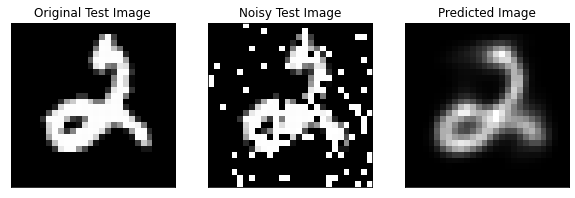

In [526]:
checktestsample(model,14)